* 下文涉及对角度的描述中，1°、1′、1″分别表示角度1度、1分、1秒，1°= 60′= 3600″。
* 数据集涉及GeoTIFF和NetCDF两种格式的文件。这两种文件都可以采用Python和R等开源编程软件处理，也可以采用地理数据处理软件如ArcGIS、GeoScene、SuperMap、QGIS等进行处理。其中QGIS是免费开源的地理信息处理软件，任何人都可下载使用。
* QGIS官方网站：https://qgis.org/
* QGIS教程：https://docs.qgis.org/3.34/en/docs/training_manual/index.html
				https://www.osgeo.cn/qgis-tutorial/index.html（中文教程）

* 1.中国数字高程图（1km）

* 2.中国0.1°近地表气温数据集（1979-2018年）

* 3.中国大陆0.25°逐日降水数据集（1961-2022年）

* 4.中国0.5°土地利用和覆盖变化数据集（1900-2019年）

* 5.中国大陆1km逐年历史人口空间分布公里网格数据集（1990-2015年）

* 6.中国大陆1km逐年历史GDP空间分布公里网格数据集（1990-2015年）

### 问题4.在中国级别的尺度上，描述自然地理特征的地形可以概括为“三级阶梯”，而降水中具有标志性意义的“800mm等降水量线”则与区分我国南北方的“秦岭—淮河”一线大体重合；描述人文地理特征的人口分布及其社会经济活动总量等指标，则被由连接黑龙江黑河与云南腾冲的“胡焕庸线”清晰地划分成东密西疏的两部分。那么，对于自然地理和人文地理交汇点的土地利用/土地覆被情况，结合其在前三问中描述、估计和预测任务中的“特性”，利用地理大数据，建立相应的数学模型，对数据进行简化和综合，描述中国土地利用变化的特征与结构。从准确性和有用性两个方面解释验证你们的总结。

#### 用高程和温度数据来解释降水，用高程和降水来解释温度，即可说明三者之间的相互作用

In [33]:
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show
import numpy as np
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas as pd
import warnings
import cv2  # OpenCV用于处理图像

# 忽略所有的警告
warnings.filterwarnings("ignore")

# 设置字体为 SimHei（黑体）以支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用黑体显示中文
plt.rcParams['axes.unicode_minus'] = False    # 解决负号


In [34]:
def img_show(name,image_data,bounds,width,height,style,cmap_wid):
    left, bottom, right, top = bounds
    # 计算图像的网格经纬度
    xs = np.linspace(left, right, width)
    ys = np.linspace(bottom, top, height)
    X, Y = np.meshgrid(xs, ys)

    # 显示 GeoTIFF 图像
    plt.figure(figsize=(10, 6))
    plt.imshow(image_data, cmap=style, extent=[left, right, bottom, top])
    plt.title(name,fontsize = 20)
    plt.xlabel('经度',fontsize = 20)
    plt.ylabel('纬度',fontsize = 20)
    #plt.colorbar(label='降水量')  # 添加标签

    # 获取当前轴
    ax = plt.gca()

    # 使用 make_axes_locatable 创建一个分隔器，控制 colorbar 的位置和大小
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)  # 调整 colorbar 宽度和与图像的间距
    # 添加颜色条
    cbar = plt.colorbar(cax=cax)

    # 设置颜色条的宽高比，使其更短或更长
    cax.set_aspect(cmap_wid)  # 值越大，颜色条越短
    plt.savefig(f'问题1\\{name}.png', bbox_inches='tight')
    
###植被数据读写函数
def function(veg):
    ls = []
    for year in years:
        with rasterio.open(f'{file_path}\\{veg}-{year}.tif') as dataset:
            # 读取像素值
            image_data = dataset.read(1)  # 读取第一个波段的数据
            # 获取经纬度信息
            bounds = dataset.bounds
            left, bottom, right, top = bounds
            transform = dataset.transform

            # 获取图像尺寸
            width = dataset.width
            height = dataset.height

            # 计算图像的网格经纬度
            longitude = np.linspace(left, right, width)
            latitude = np.linspace(bottom, top, height)
            ls.append(image_data)
    return np.array(ls),longitude,latitude,bounds,width,height

import numpy as np
from scipy.spatial import cKDTree
def matrix_concat(xs,ys):
    matrix = []
    for i in range(xs.shape[0]):
        tem = []
        for o in range(xs.shape[1]):
            tem.append([xs[i][o],ys[i][o]])
        matrix.append(tem)
    return np.array(matrix)

def reduction(X_big,Y_big,X_small,Y_small,values):
    # 示例大矩阵 (例如包含大范围的经纬度点)
    large_lat_lon = matrix_concat(X_big,Y_big).reshape(-1,2)  # 大矩阵经纬度
    large_matrix_values = values.reshape(1,-1)[0]  # 大矩阵对应值

    # 示例小矩阵 (包含小范围的经纬度点)
    small_lat_lon = matrix_concat(X_small,Y_small).reshape(-1,2)  # 小矩阵经纬度

    # 创建KD-Tree来寻找最近邻点
    tree = cKDTree(small_lat_lon)

    # 为大矩阵中的每个经纬度点找到小矩阵中最近的点
    distances, indices = tree.query(large_lat_lon)

    # 初始化小矩阵的值为零
    small_matrix_values = np.zeros(len(small_lat_lon))

    # 初始化一个计数器，用于计算每个小矩阵点被匹配到多少次
    count = np.zeros(len(small_lat_lon))

    # 遍历大矩阵，将大矩阵的值加到相应的最近邻小矩阵点上
    for i, idx in enumerate(indices):
        small_matrix_values[idx] += large_matrix_values[i]
        count[idx] += 1

    # 对每个小矩阵点求平均值，避免被零除
    small_matrix_values = np.divide(small_matrix_values, count, out=np.zeros_like(small_matrix_values), where=count!=0)
    return small_matrix_values

### 植被数据

In [35]:
veges = ['cropland','forest','grass','shrub','wetland']
years = list(range(1990,2016))

file_path = r'F:\研究生学习\华为杯\数据集4\中国大陆0.5°土地利用和覆盖变化数据集(1900-2019年)\数据实体'

cropland,longitude,latitude,bounds,width,height = function('cropland')
forest = function('forest')[0]
grass = function('grass')[0]
shrub = function('shrub')[0]
wetland = function('wetland')[0]

left, bottom, right, top = bounds
xs_veg = np.linspace(left, right, width) #温度图的网格数据
ys_veg = np.linspace(bottom, top, height) #温度图的网格数据
X_veg, Y_veg = np.meshgrid(xs_veg, ys_veg)

#### 对于人口和GDP都要进行降维处理，才能将人口和GDP与土壤之间联合在一起分析（运行慢）

#### 由于图片太大，我们需要对其进行地理信息加权的图像降采样，我们使用OpenCV进行降采样，采用平均池化

In [36]:
import os
abs_path = r'F:\研究生学习\华为杯\数据集5\pop_output'
dirs = os.listdir(abs_path)
pop = []
for filename in dirs:
    sub_dirs = os.listdir(f'{abs_path}\\{filename}')
    for sub_file in sub_dirs:
        if  sub_file[-3:] == 'tif':
            print(sub_file)
            with rasterio.open(f'{abs_path}\\{filename}\\{sub_file}') as dataset:
                # 读取像素值
                image_data = dataset.read(1)  # 读取第一个波段的数据
                # 获取经纬度信息
                bounds = dataset.bounds
                left, bottom, right, top = 57.48,2.07,150.65,56.8
                transform = dataset.transform

                # 获取图像尺寸
                width = dataset.width
                height = dataset.height
                
                xs_pop = np.linspace(left, right, width) #温度图的网格数据
                ys_pop = np.linspace(bottom, top, height) #温度图的网格数据
                X_pop, Y_pop = np.meshgrid(xs_pop, ys_pop)
                                
                # 定义降采样比例，例如2x2的降采样
                scale_factor = 8

                # 使用OpenCV进行降采样，采用平均池化
                image_data = cv2.resize(image_data, 
                                           (image_data.shape[1] // scale_factor, image_data.shape[0] // scale_factor), 
                                           interpolation=cv2.INTER_AREA)
                X_pop = cv2.resize(X_pop, 
                                           (X_pop.shape[1] // scale_factor, X_pop.shape[0] // scale_factor), 
                                           interpolation=cv2.INTER_AREA)
                Y_pop = cv2.resize(Y_pop, 
                                           (Y_pop.shape[1] // scale_factor, Y_pop.shape[0] // scale_factor), 
                                           interpolation=cv2.INTER_AREA)
                image_data = reduction(X_pop,Y_pop,X_veg,Y_veg,image_data) #降维

                pop.append(image_data)
                
pop = np.array(pop)
pop.shape

pop1990.tif
pop1991.tif
pop1992.tif
pop1993.tif
pop1994.tif
pop1995.tif
pop1996.tif
pop1997.tif
pop1998.tif
pop1999.tif
pop2000.tif
pop2001.tif
pop2002.tif
pop2003.tif
pop2004.tif
pop2005.tif
pop2006.tif
pop2007.tif
pop2008.tif
pop2009.tif
pop2010.tif
pop2011.tif
pop2012.tif
pop2013.tif
pop2014.tif
pop2015.tif


(26, 9906)

In [37]:
import os
abs_path = r'F:\研究生学习\华为杯\数据集6\GDP_output'
dirs = os.listdir(abs_path)
gdp = []
for filename in dirs:
    if  filename[-3:] == 'tif':
        with rasterio.open(f'{abs_path}\\{filename}') as dataset:
            # 读取像素值
            image_data = dataset.read(1)  # 读取第一个波段的数据
            # 获取经纬度信息
            bounds = dataset.bounds
            left, bottom, right, top = 52.01,0.88,154.49,57.8
            transform = dataset.transform

            # 获取图像尺寸
            width = dataset.width
            height = dataset.height

            xs_gdp = np.linspace(left, right, width) #温度图的网格数据
            ys_gdp = np.linspace(bottom, top, height) #温度图的网格数据
            X_gdp, Y_gdp = np.meshgrid(xs_gdp, ys_gdp)
            
            # 定义降采样比例，例如2x2的降采样
            scale_factor = 8

            # 使用OpenCV进行降采样，采用平均池化
            image_data = cv2.resize(image_data.astype(np.float32), 
                                       (image_data.shape[1] // scale_factor, image_data.shape[0] // scale_factor), 
                                       interpolation=cv2.INTER_AREA)
            X_gdp = cv2.resize(X_gdp, 
                                       (X_gdp.shape[1] // scale_factor, X_gdp.shape[0] // scale_factor), 
                                       interpolation=cv2.INTER_AREA)
            Y_gdp = cv2.resize(Y_gdp, 
                                       (Y_gdp.shape[1] // scale_factor, Y_gdp.shape[0] // scale_factor), 
                                       interpolation=cv2.INTER_AREA)
            image_data = reduction(X_gdp,Y_gdp,X_veg,Y_veg,image_data) #降维
            gdp.append(image_data)
gdp = np.array(gdp)
gdp.shape

(26, 9906)

In [38]:
ll = matrix_concat(X_veg,Y_veg).reshape(-1,2) #经纬度
lonlatitude = np.array([ll for i in gdp])

dataset = pd.DataFrame()
dataset['人口'] = pop.reshape(1,-1)[0]
dataset['GDP'] = gdp.reshape(1,-1)[0]

dataset['耕地'] = cropland.reshape(1,-1)[0]
dataset['森林'] = forest.reshape(1,-1)[0]
dataset['草地'] = grass.reshape(1,-1)[0]
dataset['灌木'] = shrub.reshape(1,-1)[0]
dataset['湿地'] = wetland.reshape(1,-1)[0]
dataset['经度'] = lonlatitude.reshape(-1,2)[:,0]
dataset['纬度'] = lonlatitude.reshape(-1,2)[:,1]

dataset['年'] = np.array([o for i in range(cropland.shape[1]*cropland.shape[2]) for o in range(1990,2016)])

dataset['是否中国'] = 1
dataset.loc[(dataset.人口<0)|(dataset.GDP<0)|((dataset.耕地==0)&(dataset.森林==0)&(dataset.草地==0)&(dataset.灌木==0)&(dataset.湿地==0)),'是否中国'] = 0

result = dataset[dataset.是否中国==1].sort_values(by=['经度','纬度'])

result

人口          GDP        耕地        森林        草地        灌木  \
212092    0.984083     0.555331  0.000000  0.001787  0.998213  0.000000   
221998    1.001516     0.416498  0.000000  0.001879  0.998121  0.000000   
231904    1.018948     0.277665  0.000000  0.001971  0.998029  0.000000   
241810    1.036381     0.138833  0.000000  0.001964  0.998036  0.000000   
212219    0.868768     0.859263  0.000000  0.000000  0.999991  0.000000   
...            ...          ...       ...       ...       ...       ...   
239124   99.069515  1638.755945  0.087697  0.151058  0.731892  0.000000   
209533  199.963988   704.901291  0.250544  0.208614  0.456131  0.015926   
219439  202.453004   765.470326  0.249183  0.211552  0.454903  0.015884   
229345  204.942012   826.092264  0.248529  0.214554  0.452930  0.015815   
239251  207.431027   886.661331  0.247517  0.217741  0.451125  0.015752   

              湿地          经度         纬度     年  是否中国  
212092  0.000000   73.232936  32.782792  2000     1  
221998  0.000000   73.232936  32.782792  2000     1  
231904  0.000000   73.232936  32.782792  2000     1  
241810  0.000000   73.232936  32.782792  2000     1  
212219  0.000009   73.232936  33.289286  1997     1  
...          ...         ...        ...   ...   ...  
239124  0.029354  127.661508  21.639935  1992     1  
209533  0.068785  127.661508  22.146429  2015     1  
219439  0.068478  127.661508  22.146429  2015     1  
229345  0.068172  127.661508  22.146429  2015     1  
239251  0.067865  127.661508  22.146429  2015     1  

[40514 rows x 11 columns]

#### 秦岭淮河线

In [39]:
from shapely.geometry import Point, LineString

def classify_by_qinling_huaihe(longitude, latitude):
    
    # 定义秦岭-淮河线的大致经纬度端点
    qinling_huaihe_line = LineString([(105.0, 34.0), (120.0, 32.0)])  # 秦岭到淮河的大致线段
    
    # 创建输入点
    location = Point(longitude, latitude)
    
    # 判断该点在秦岭-淮河线的南侧还是北侧
    if location.y > qinling_huaihe_line.interpolate(qinling_huaihe_line.project(location)).y:
        return "北"
    else:
        return "南"

# 示例经纬度
longitude = 110.0  # 经度
latitude = 35.0    # 纬度

# 调用函数
result['秦岭淮河'] = [classify_by_qinling_huaihe(i, o) for i,o in zip(result['经度'].values,result['纬度'].values)]
result


人口          GDP        耕地        森林        草地        灌木  \
212092    0.984083     0.555331  0.000000  0.001787  0.998213  0.000000   
221998    1.001516     0.416498  0.000000  0.001879  0.998121  0.000000   
231904    1.018948     0.277665  0.000000  0.001971  0.998029  0.000000   
241810    1.036381     0.138833  0.000000  0.001964  0.998036  0.000000   
212219    0.868768     0.859263  0.000000  0.000000  0.999991  0.000000   
...            ...          ...       ...       ...       ...       ...   
239124   99.069515  1638.755945  0.087697  0.151058  0.731892  0.000000   
209533  199.963988   704.901291  0.250544  0.208614  0.456131  0.015926   
219439  202.453004   765.470326  0.249183  0.211552  0.454903  0.015884   
229345  204.942012   826.092264  0.248529  0.214554  0.452930  0.015815   
239251  207.431027   886.661331  0.247517  0.217741  0.451125  0.015752   

              湿地          经度         纬度     年  是否中国 秦岭淮河  
212092  0.000000   73.232936  32.782792  2000     1    南  
221998  0.000000   73.232936  32.782792  2000     1    南  
231904  0.000000   73.232936  32.782792  2000     1    南  
241810  0.000000   73.232936  32.782792  2000     1    南  
212219  0.000009   73.232936  33.289286  1997     1    南  
...          ...         ...        ...   ...   ...  ...  
239124  0.029354  127.661508  21.639935  1992     1    南  
209533  0.068785  127.661508  22.146429  2015     1    南  
219439  0.068478  127.661508  22.146429  2015     1    南  
229345  0.068172  127.661508  22.146429  2015     1    南  
239251  0.067865  127.661508  22.146429  2015     1    南  

[40514 rows x 12 columns]

In [40]:
from shapely.geometry import Point, LineString

def classify_by_huhuan_yong_line(longitude, latitude):
    
    # 定义胡焕庸线的大致经纬度端点
    huhuan_yong_line = LineString([(127.0, 50.0), (98.0, 25.0)])  # 黑河到腾冲的大致线段
    
    # 创建输入点
    location = Point(longitude, latitude)
    
    # 判断该点在胡焕庸线的东南侧还是西北侧
    if location.y > huhuan_yong_line.interpolate(huhuan_yong_line.project(location)).y:
        return "东"
    else:
        return "西"

result['胡焕庸线'] = [classify_by_huhuan_yong_line(i, o) for i,o in zip(result['经度'].values,result['纬度'].values)]
result = result.groupby(['秦岭淮河','胡焕庸线','年']).mean().reset_index()
result

秦岭淮河 胡焕庸线     年          人口           GDP        耕地        森林        草地  \
0      北    东  1990  146.454053   6959.797812  0.167406  0.185682  0.508061   
1      北    东  1991  141.268775  40033.708200  0.180573  0.191000  0.475067   
2      北    东  1992  127.985736  26427.435809  0.167657  0.187443  0.487629   
3      北    东  1993  138.196682  31285.935738  0.153360  0.163173  0.531582   
4      北    东  1994  126.410238  27067.749612  0.143409  0.166782  0.536245   
..   ...  ...   ...         ...           ...       ...       ...       ...   
99     南    西  2011  445.749720  29471.903272  0.144581  0.128650  0.586264   
100    南    西  2012  501.690634  21537.894842  0.165304  0.138949  0.558522   
101    南    西  2013  449.447643  12830.888463  0.138396  0.141657  0.546786   
102    南    西  2014  474.030706  20501.067510  0.123757  0.148298  0.554710   
103    南    西  2015  407.702164   1838.991945  0.100753  0.158465  0.583265   

           灌木        湿地          经度         纬度  是否中国  
0    0.110397  0.028454  102.278914  38.895294   1.0  
1    0.108712  0.044648  102.463095  38.823114   1.0  
2    0.115653  0.041617  101.847620  38.701405   1.0  
3    0.113221  0.038665  102.235595  38.455725   1.0  
4    0.133167  0.020398  101.992066  38.409394   1.0  
..        ...       ...         ...        ...   ...  
99   0.121760  0.018745  114.703463  27.982324   1.0  
100  0.111067  0.026159  117.044326  28.186553   1.0  
101  0.140528  0.032634  116.968950  28.181982   1.0  
102  0.144674  0.028561  116.393979  28.177391   1.0  
103  0.122302  0.035215  115.787666  27.404592   1.0  

[104 rows x 13 columns]

### 1. **人口密度**（需面积数据）
如果你有省份的面积数据：
$$
\text{人口密度} = \frac{\text{人口总量}}{\text{省份总面积}}
$$

### 2. **耕地率**
耕地率直接使用耕地覆盖率：
$$
\text{耕地率} = \text{耕地覆盖率}
$$

### 3. **绿地率**
绿地率是森林、灌木、草地和湿地覆盖率的总和：
$$
\text{绿地率} = \text{森林覆盖率} + \text{灌木覆盖率} + \text{草地覆盖率} + \text{湿地覆盖率}
$$

### 4. **人均GDP**
人均GDP表示经济发展水平：
$$
\text{人均GDP} = \frac{\text{GDP总量}}{\text{人口总量}}
$$

### 5. **种植效率**
衡量土地的经济贡献，可以通过GDP和耕地覆盖率来计算：
$$
\text{种植效率} = \frac{\text{GDP总量}}{\text{耕地覆盖率}}
$$

### 6. **人均绿地覆盖率**
用绿地率除以人口总量，可以得出人均绿地覆盖率：
$$
\text{人均绿地覆盖率} = \frac{\text{绿地率}}{\text{人口总量}}
$$

这些公式有助于分析城市化和可持续发展水平。

In [41]:
def calculate_indicators(population, gdp, farmland_rate, forest_rate, shrubland_rate, grassland_rate, wetland_rate):
   
    # 1. 耕地率 (直接使用耕地覆盖率)
    cultivated_land_rate = farmland_rate

    # 2. 绿地率 (森林、灌木、草地、湿地覆盖率的总和)
    green_space_rate = forest_rate + shrubland_rate + grassland_rate + wetland_rate

    # 3. 人均GDP
    per_capita_gdp = gdp / population if population != 0 else 0

    # 4. 种植效率 (GDP / 耕地覆盖率)
    land_use_efficiency = gdp / farmland_rate if farmland_rate != 0 else 0

    # 5. 人均绿地覆盖率
    per_capita_green_space_rate = green_space_rate / population if population != 0 else 0

    return {
        "耕地率": cultivated_land_rate,
        "绿地率": green_space_rate,
        "人均GDP": per_capita_gdp,
        "土地利用效率": land_use_efficiency,
        "人均绿地覆盖率": per_capita_green_space_rate
    }

col = ['耕地率', '绿地率', '人均GDP', '种植效率', '人均绿地覆盖率']
# 调用函数进行计算
ls = []
for a,b,c,d,e,f,g in result[['人口', 'GDP', '耕地', '森林', '灌木','草地', '湿地']].values:
    ls.append(list(calculate_indicators(a, b, c, d, e, f, g).values()))
cat = pd.DataFrame(ls,columns=col)
result = pd.concat([cat,result.reset_index(drop=True)],axis=1)
result

耕地率       绿地率       人均GDP           种植效率   人均绿地覆盖率 秦岭淮河 胡焕庸线     年  \
0    0.167406  0.832594   47.522057   41574.338894  0.005685    北    东  1990   
1    0.180573  0.819427  283.386816  221703.950816  0.005800    北    东  1991   
2    0.167657  0.832343  206.487353  157627.608440  0.006503    北    东  1992   
3    0.153360  0.846640  226.387025  204003.577075  0.006126    北    东  1993   
4    0.143409  0.856591  214.126245  188745.577459  0.006776    北    东  1994   
..        ...       ...         ...            ...       ...  ...  ...   ...   
99   0.144581  0.855419   66.117604  203843.640897  0.001919    南    西  2011   
100  0.165304  0.834696   42.930630  130292.426225  0.001664    南    西  2012   
101  0.138396  0.861604   28.548127   92711.384661  0.001917    南    西  2013   
102  0.123757  0.876243   43.248396  165655.795285  0.001848    南    西  2014   
103  0.100753  0.899247    4.510626   18252.490093  0.002206    南    西  2015   

             人口           GDP        耕地        森林        草地        灌木  \
0    146.454053   6959.797812  0.167406  0.185682  0.508061  0.110397   
1    141.268775  40033.708200  0.180573  0.191000  0.475067  0.108712   
2    127.985736  26427.435809  0.167657  0.187443  0.487629  0.115653   
3    138.196682  31285.935738  0.153360  0.163173  0.531582  0.113221   
4    126.410238  27067.749612  0.143409  0.166782  0.536245  0.133167   
..          ...           ...       ...       ...       ...       ...   
99   445.749720  29471.903272  0.144581  0.128650  0.586264  0.121760   
100  501.690634  21537.894842  0.165304  0.138949  0.558522  0.111067   
101  449.447643  12830.888463  0.138396  0.141657  0.546786  0.140528   
102  474.030706  20501.067510  0.123757  0.148298  0.554710  0.144674   
103  407.702164   1838.991945  0.100753  0.158465  0.583265  0.122302   

           湿地          经度         纬度  是否中国  
0    0.028454  102.278914  38.895294   1.0  
1    0.044648  102.463095  38.823114   1.0  
2    0.041617  101.847620  38.701405   1.0  
3    0.038665  102.235595  38.455725   1.0  
4    0.020398  101.992066  38.409394   1.0  
..        ...         ...        ...   ...  
99   0.018745  114.703463  27.982324   1.0  
100  0.026159  117.044326  28.186553   1.0  
101  0.032634  116.968950  28.181982   1.0  
102  0.028561  116.393979  28.177391   1.0  
103  0.035215  115.787666  27.404592   1.0  

[104 rows x 18 columns]

### 然后使用AHP层次分析法对这些指标进行权重分配

AHP（层次分析法）是一种多准则决策方法，通过构建评价矩阵，利用特征向量计算每个指标的权重，最终为每个决策提供综合评分。以下是 AHP 方法的具体实现流程：

### 步骤
1. **构建评价矩阵**：需要创建一个关于每个指标两两对比的专家评价矩阵。
2. **计算权重**：通过求取评价矩阵的特征向量，得到每个指标的权重。
3. **计算一致性比率**：检查专家评价矩阵的一致性，确保权重的合理性。
4. **计算总得分**：基于计算得到的权重，将每个指标的分数融合成一个综合得分。


In [42]:
import numpy as np

# 定义AHP评价矩阵
def ahp_weight(matrix):

    # 计算每列的总和
    col_sum = np.sum(matrix, axis=0)
    
    # 归一化评价矩阵
    normalized_matrix = matrix / col_sum
    
    # 计算每行的平均值，得到特征向量近似
    weights = np.mean(normalized_matrix, axis=1)
    
    return weights

# 定义一致性检验函数
def consistency_ratio(matrix, weights):
    
    n = matrix.shape[0]
    
    # 计算一致性指标 CI
    lambda_max = np.sum(np.dot(matrix, weights) / weights) / n
    ci = (lambda_max - n) / (n - 1)
    
    # 随机一致性指标 (RI) 对应的值，取决于矩阵维度 n
    ri_table = {1: 0.00, 2: 0.00, 3: 0.58, 4: 0.90, 5: 1.12, 6: 1.24, 7: 1.32, 8: 1.41, 9: 1.45, 10: 1.49}
    ri = ri_table.get(n, 1.49)  # n大于10时，使用1.49
    
    # 计算一致性比率 CR
    cr = ci / ri if ri != 0 else 0
    
    return cr


# 计算总得分
def calculate_total_score(scores, weights):

    return np.dot(scores, weights)


# 定义6个指标的专家评价矩阵
# expert_matrix = np.array([
#     [1, 3, 5, 7, 2],  # 指标1对其他指标的相对重要性
#     [1/3, 1, 2, 4, 1/2],
#     [1/5, 1/2, 1, 3, 1/3],
#     [1/7, 1/4, 1/3, 1, 1/5],
#     [1/2, 2, 3, 5, 1]
# ])
expert_matrix = np.array([
    [1, 4, 6, 8, 3],  # 提高第一个指标的重要性
    [1/4, 1, 2, 4, 1/2],
    [1/6, 1/2, 1, 3, 1/3],
    [1/8, 1/4, 1/3, 1, 1/5],
    [1/3, 2, 3, 5, 1]
])
# 计算指标权重
weights = ahp_weight(expert_matrix)

# 打印权重
print("各指标的权重为:")
for i, weight in enumerate(weights, start=0):
    print(f"指标{col[i]}的权重: {weight:.4f}")

# 检查一致性
cr = consistency_ratio(expert_matrix, weights)
print(f"一致性比率 CR: {cr:.4f}")

if cr < 0.1:
    print("评价矩阵的一致性良好，可以使用计算的权重。")
else:
    print("评价矩阵一致性较差，建议重新评估。")
    

各指标的权重为:
指标耕地率的权重: 0.5026
指标绿地率的权重: 0.1429
指标人均GDP的权重: 0.0887
指标种植效率的权重: 0.0427
指标人均绿地覆盖率的权重: 0.2232
一致性比率 CR: 0.0252
评价矩阵的一致性良好，可以使用计算的权重。


#### 这里可以根据自己的期望设计评价矩阵，从而获得对应的不同指标权重

#### 计算前，我们对数据按照秦岭淮河和胡焕庸线进行聚合，再对指标进行标准化，使得AHP分数在0-1之间

In [43]:
from sklearn.preprocessing import MinMaxScaler

ls = []
value = result[col].values
# 创建 StandardScaler 对象
scaler = MinMaxScaler()

# 对数据进行标准化
standardized_data = scaler.fit_transform(value)

for a,b,c,d,e in standardized_data:
    ls.append(calculate_total_score(np.array([a,b,c,d,e]), weights))
result['AHP分数'] = ls
result.index = result['年']
#result.to_excel('问题4\\处理后数据.xlsx')

result

耕地率       绿地率       人均GDP           种植效率   人均绿地覆盖率 秦岭淮河 胡焕庸线     年  \
年                                                                               
1990  0.167406  0.832594   47.522057   41574.338894  0.005685    北    东  1990   
1991  0.180573  0.819427  283.386816  221703.950816  0.005800    北    东  1991   
1992  0.167657  0.832343  206.487353  157627.608440  0.006503    北    东  1992   
1993  0.153360  0.846640  226.387025  204003.577075  0.006126    北    东  1993   
1994  0.143409  0.856591  214.126245  188745.577459  0.006776    北    东  1994   
...        ...       ...         ...            ...       ...  ...  ...   ...   
2011  0.144581  0.855419   66.117604  203843.640897  0.001919    南    西  2011   
2012  0.165304  0.834696   42.930630  130292.426225  0.001664    南    西  2012   
2013  0.138396  0.861604   28.548127   92711.384661  0.001917    南    西  2013   
2014  0.123757  0.876243   43.248396  165655.795285  0.001848    南    西  2014   
2015  0.100753  0.899247    4.510626   18252.490093  0.002206    南    西  2015   

              人口           GDP        耕地        森林        草地        灌木  \
年                                                                        
1990  146.454053   6959.797812  0.167406  0.185682  0.508061  0.110397   
1991  141.268775  40033.708200  0.180573  0.191000  0.475067  0.108712   
1992  127.985736  26427.435809  0.167657  0.187443  0.487629  0.115653   
1993  138.196682  31285.935738  0.153360  0.163173  0.531582  0.113221   
1994  126.410238  27067.749612  0.143409  0.166782  0.536245  0.133167   
...          ...           ...       ...       ...       ...       ...   
2011  445.749720  29471.903272  0.144581  0.128650  0.586264  0.121760   
2012  501.690634  21537.894842  0.165304  0.138949  0.558522  0.111067   
2013  449.447643  12830.888463  0.138396  0.141657  0.546786  0.140528   
2014  474.030706  20501.067510  0.123757  0.148298  0.554710  0.144674   
2015  407.702164   1838.991945  0.100753  0.158465  0.583265  0.122302   

            湿地          经度         纬度  是否中国     AHP分数  
年                                                      
1990  0.028454  102.278914  38.895294   1.0  0.247553  
1991  0.044648  102.463095  38.823114   1.0  0.256995  
1992  0.041617  101.847620  38.701405   1.0  0.249125  
1993  0.038665  102.235595  38.455725   1.0  0.239983  
1994  0.020398  101.992066  38.409394   1.0  0.234228  
...        ...         ...        ...   ...       ...  
2011  0.018745  114.703463  27.982324   1.0  0.230368  
2012  0.026159  117.044326  28.186553   1.0  0.242982  
2013  0.032634  116.968950  28.181982   1.0  0.226271  
2014  0.028561  116.393979  28.177391   1.0  0.217162  
2015  0.035215  115.787666  27.404592   1.0  0.202809  

[104 rows x 19 columns]

#### 现在，我们可以对不同地区的情况进行分析了,我们根据秦岭淮河和胡焕庸线将中国划分为东南西北四个地区，基于四个地区进行分析

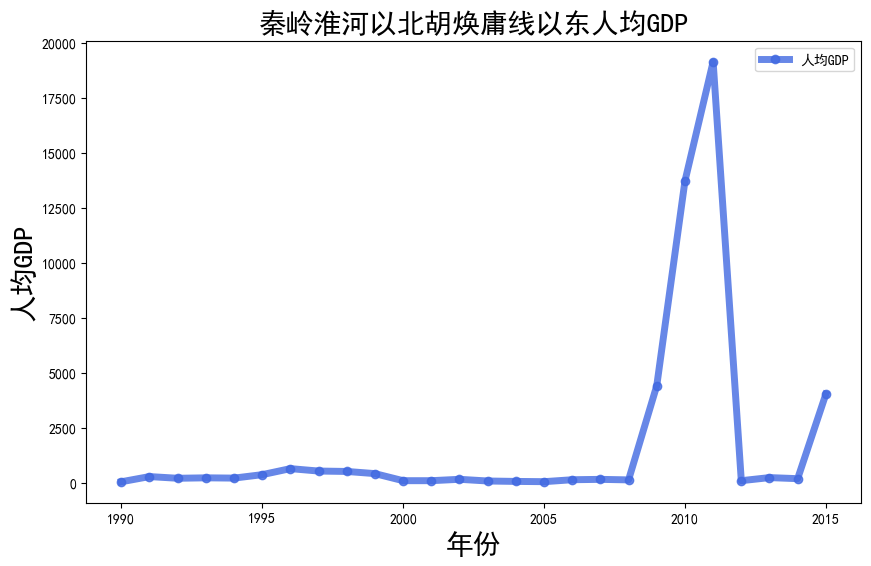

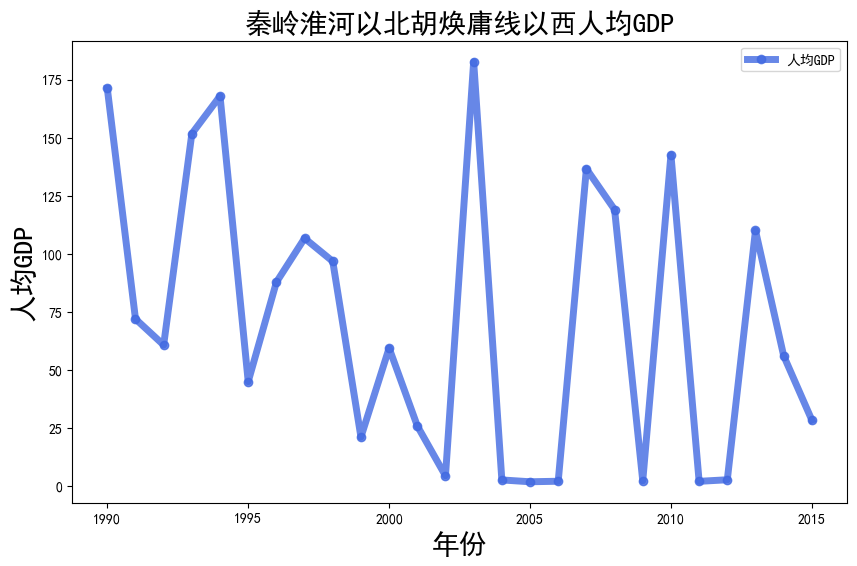

In [62]:
for qin in result['秦岭淮河'].unique():
    for hu in result['胡焕庸线'].unique():
        tem = result[(result.秦岭淮河==qin)&(result.胡焕庸线==hu)]
        tem['人均GDP'].plot(kind = "line",figsize = (10,6),linestyle='-',marker='o',markerfacecolor='royalblue',alpha=0.8,linewidth=5,color='royalblue') #颜色,matplotlib
        plt.xticks(rotation=0)
        plt.title(f'秦岭淮河以{qin}胡焕庸线以{hu}人均GDP',fontsize = 20)
        plt.xlabel("年份",fontsize = 20)
        plt.ylabel("人均GDP",fontsize = 20)
        plt.savefig(f'F:\研究生学习\华为杯\第四问图片\\秦岭淮河以{qin}胡焕庸线以{hu}人均GDP.png',dpi=500)
        plt.legend()
        plt.show()

In [51]:
colors = ['royalblue', 'orangered', 'magenta', 'forestgreen']
i=0
for qin in result['秦岭淮河'].unique():
    for hu in result['胡焕庸线'].unique():
        tem = result[(result.秦岭淮河==qin)&(result.胡焕庸线==hu)]
        tem['耕地率'].plot(kind = "line",figsize = (10,6),linestyle='-',marker='o',markerfacecolor=colors[i],alpha=0.8,linewidth=5,label=f'{hu}{qin}',color=colors[i]) #颜色,matplotlib
        i=i+1
plt.xticks(rotation=0)
plt.title(f'四个地区耕地率',fontsize = 20)
plt.xlabel("年份",fontsize = 20)
plt.ylabel("耕地率",fontsize = 20)
plt.savefig(f'F:\研究生学习\华为杯\第四问图片\\秦岭淮河以{qin}胡焕庸线以{hu}耕地率.png',dpi=500)
plt.legend()
plt.show()

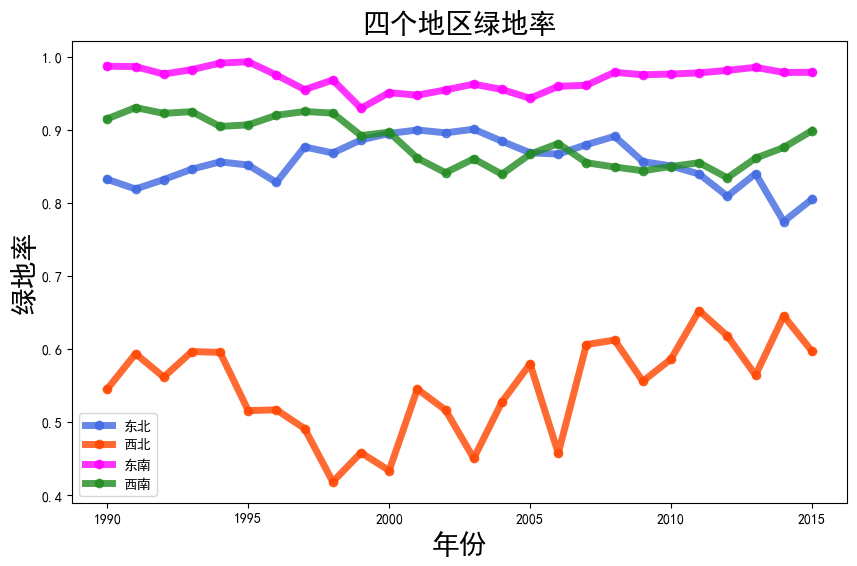

In [53]:
colors = ['royalblue', 'orangered', 'magenta', 'forestgreen']
i=0
for qin in result['秦岭淮河'].unique():
    for hu in result['胡焕庸线'].unique():
        tem = result[(result.秦岭淮河==qin)&(result.胡焕庸线==hu)]
        tem['绿地率'].plot(kind = "line",figsize = (10,6),linestyle='-',marker='o',markerfacecolor=colors[i],alpha=0.8,linewidth=5,label=f'{hu}{qin}',color=colors[i]) #颜色,matplotlib
        i=i+1
plt.xticks(rotation=0)
plt.title(f'四个地区绿地率',fontsize = 20)
plt.xlabel("年份",fontsize = 20)
plt.ylabel("绿地率",fontsize = 20)
plt.savefig(f'F:\研究生学习\华为杯\第四问图片\\秦岭淮河以{qin}胡焕庸线以{hu}绿地率.png',dpi=500)
plt.legend()
plt.show()

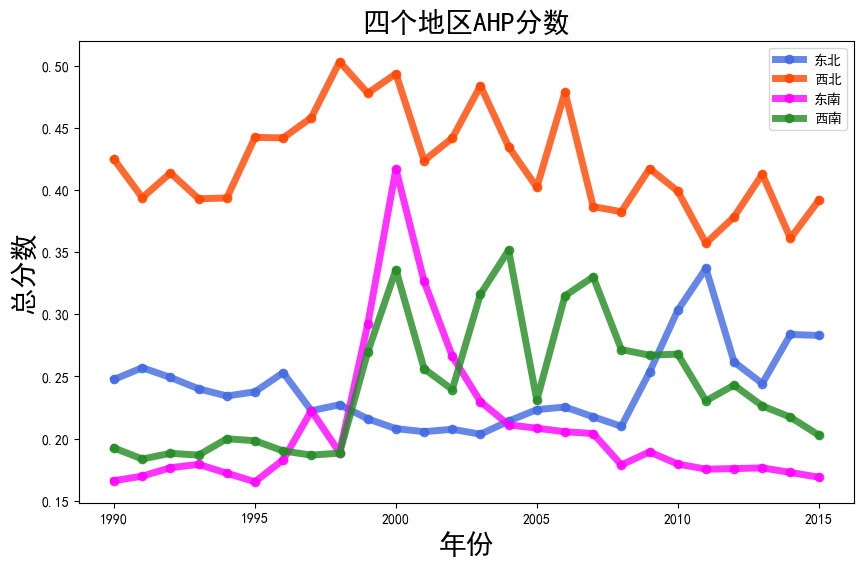

In [54]:
colors = ['royalblue', 'orangered', 'magenta', 'forestgreen']
i=0
for qin in result['秦岭淮河'].unique():
    for hu in result['胡焕庸线'].unique():
        tem = result[(result.秦岭淮河==qin)&(result.胡焕庸线==hu)]
        tem['AHP分数'].plot(kind = "line",figsize = (10,6),linestyle='-',marker='o',markerfacecolor=colors[i],alpha=0.8,linewidth=5,label=f'{hu}{qin}',color=colors[i]) #颜色,matplotlib
        i=i+1
plt.xticks(rotation=0)
plt.title(f'四个地区AHP分数',fontsize = 20)
plt.xlabel("年份",fontsize = 20)
plt.ylabel("总分数",fontsize = 20)
plt.savefig(f'F:\研究生学习\华为杯\第四问图片\\秦岭淮河以{qin}胡焕庸线以{hu}AHP分数.png',dpi=500)
plt.legend()
plt.show()

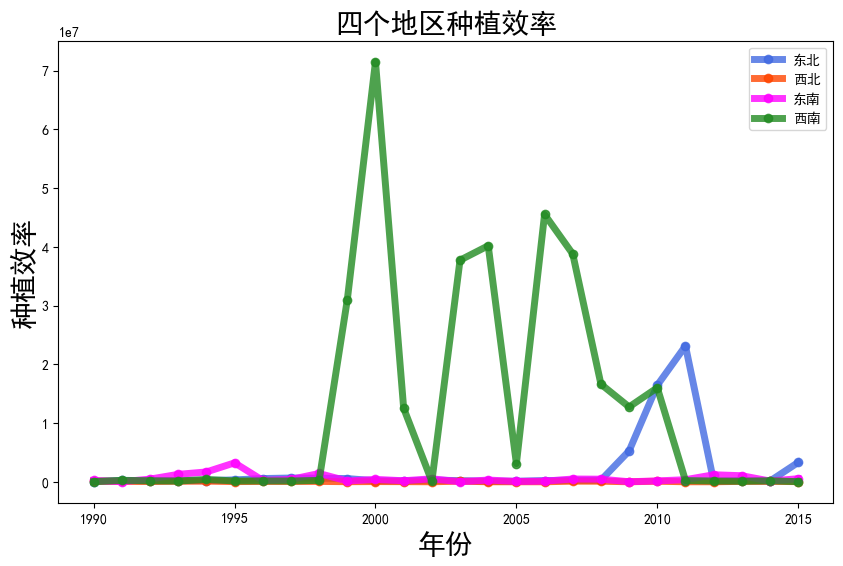

In [57]:
colors = ['royalblue', 'orangered', 'magenta', 'forestgreen']
i=0
for qin in result['秦岭淮河'].unique():
    for hu in result['胡焕庸线'].unique():
        tem = result[(result.秦岭淮河==qin)&(result.胡焕庸线==hu)]
        tem['种植效率'].plot(kind = "line",figsize = (10,6),linestyle='-',marker='o',markerfacecolor=colors[i],alpha=0.8,linewidth=5,label=f'{hu}{qin}',color=colors[i]) #颜色,matplotlib
        i=i+1
plt.xticks(rotation=0)
plt.title(f'四个地区种植效率',fontsize = 20)
plt.xlabel("年份",fontsize = 20)
plt.ylabel("种植效率",fontsize = 20)
plt.savefig(f'F:\研究生学习\华为杯\第四问图片\\秦岭淮河以{qin}胡焕庸线以{hu}种植效率.png',dpi=500)
plt.legend()
plt.show()

年
1990    0.001941
1991    0.002452
1992    0.002206
1993    0.002226
1994    0.002249
1995    0.002521
1996    0.002478
1997    0.002404
1998    0.002435
1999    0.002761
2000    0.002544
2001    0.002570
2002    0.002818
2003    0.002563
2004    0.002667
2005    0.002766
2006    0.002825
2007    0.002735
2008    0.002216
2009    0.002233
2010    0.002085
2011    0.001919
2012    0.001664
2013    0.001917
2014    0.001848
2015    0.002206
Name: 人均绿地覆盖率, dtype: float64


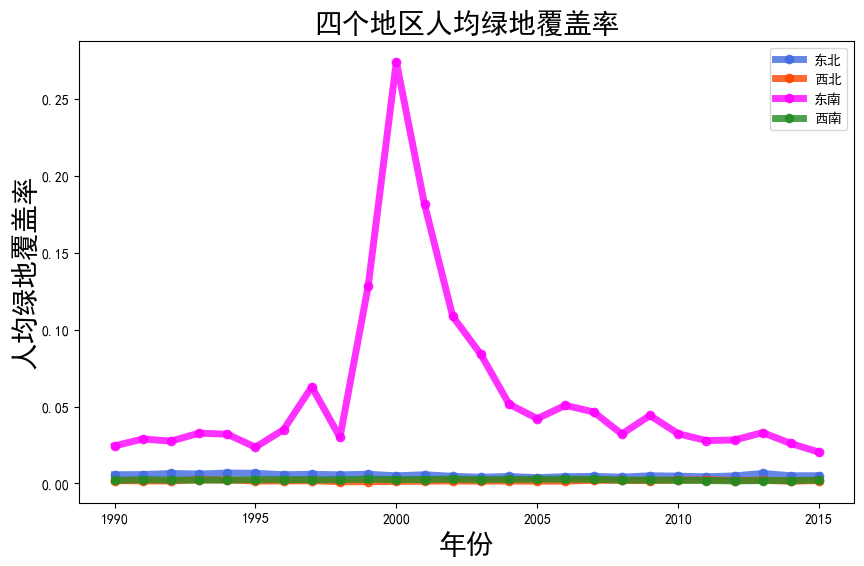

In [61]:

colors = ['royalblue', 'orangered', 'magenta', 'forestgreen']
i=0

for qin in result['秦岭淮河'].unique():
    for hu in result['胡焕庸线'].unique():
        tem = result[(result.秦岭淮河==qin)&(result.胡焕庸线==hu)]
        tem['人均绿地覆盖率'].plot(kind = "line",figsize = (10,6),linestyle='-',marker='o',markerfacecolor=colors[i],alpha=0.8,linewidth=5,label=f'{hu}{qin}',color=colors[i]) #颜色,matplotlib
        if hu=='西' and qin=='南':
            print(tem['人均绿地覆盖率'])
        i=i+1
plt.xticks(rotation=0)
plt.title(f'四个地区人均绿地覆盖率',fontsize = 20)
plt.xlabel("年份",fontsize = 20)
plt.ylabel("人均绿地覆盖率",fontsize = 20)
plt.savefig(f'F:\研究生学习\华为杯\第四问图片\\秦岭淮河以{qin}胡焕庸线以{hu}人均绿地覆盖率.png',dpi=500)
plt.legend()
plt.show()